In [1]:
## Importing needed packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data

from astropy.wcs import WCS
from astropy import wcs
import sys
from astropy.visualization import make_lupton_rgb
from sklearn import preprocessing #only works for dimensions <=2

#For plotting Gaussian
from scipy.optimize import curve_fit
from astropy import modeling
from scipy.stats import norm
import math
import seaborn as sns
from scipy.signal import find_peaks
import scipy.stats as stats
import scipy.stats
from scipy import ndimage

In [2]:
location = "/Users/RuheeJanmohamed/Desktop/Data/co_zero_south.fits"

hdul = fits.open(location)

hdu_zero_south = hdul[0]

co_zero_south = hdu_zero_south.data

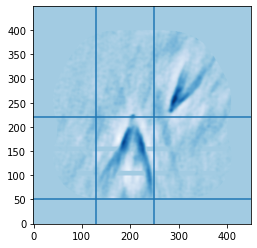

In [85]:
plt.imshow(co_zero_south,cmap='Blues',origin='lower')
plt.axvline(130)
plt.axvline(250)
plt.axhline(220)
plt.axhline(50)

[2080.10331364  224.92804539    6.66160656 -851.7214443   233.63605501
    2.77462103]


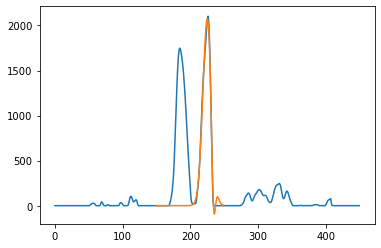

In [8]:
cut = co_zero_south[150:160,:]
cut[cut<0]=0
avg_cut = np.mean(cut,axis=0)

plt.plot(range(450),avg_cut)


#Defining Double Gaussian

def Double_Gauss(x,amp_1,mean_1,sigma_1,amp_2,mean_2,sigma_2):
    f = (amp_1 * np.exp(-(x - mean_1)**2/(2*sigma_1**2))+ (amp_2 * np.exp(-(x-mean_2)**2/(2*sigma_2**2))))
    return f

xdata=np.arange(150,250)
idata=avg_cut[150:250]



p0 = (np.max(idata),xdata[np.argmax(idata)],5,np.max(idata),xdata[np.argmax(idata)]+15,5)


p_opt,p_cov = curve_fit(Double_Gauss,xdata,idata,p0,maxfev=9000)
plt.plot(xdata,Double_Gauss(xdata,p_opt[0],p_opt[1],p_opt[2],p_opt[3],p_opt[4],p_opt[5]))
print(p_opt)



In [115]:
ycut_list = [(70+((i)*5),70+((i+1)*5)) for i in range(30)]

print(ycut_list)

[(70, 75), (75, 80), (80, 85), (85, 90), (90, 95), (95, 100), (100, 105), (105, 110), (110, 115), (115, 120), (120, 125), (125, 130), (130, 135), (135, 140), (140, 145), (145, 150), (150, 155), (155, 160), (160, 165), (165, 170), (170, 175), (175, 180), (180, 185), (185, 190), (190, 195), (195, 200), (200, 205), (205, 210), (210, 215), (215, 220)]


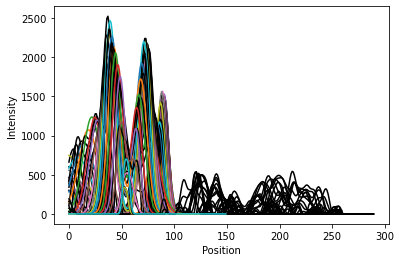

In [116]:

Model_Values = open("South(DG)_Model_Values.txt", "w")

# Model_Values.write("Left Hand Gaussian \n")
Model_Values.write("y_cut\tfit_pk_1\tfit_x_1\tfit_s_1\tfit_pk_2\tfit_x_2\tfit_s_2\tfit_pk_e\tfit_x_e\tfit_s_e\tx_c1\tx_c2\tpk_c1\tpk_c2\n")

offset_x1 = 150 #150
offset_x2 = 440

first = 0

for ycut in ycut_list:
    cut = co_zero_south[ycut[0]:ycut[1],offset_x1:offset_x2]
    avg_cut = np.mean(cut,axis=0)
    avg_cut[avg_cut<0]=0 #doesn't change original image
    xdata=np.arange(0,150)
    idata=avg_cut[0:150] #5:120
    
    if (first < 1): #giving it intial first guess
        p0 = (np.max(idata),xdata[np.argmax(idata)],5,np.max(idata),xdata[np.argmax(idata)]-100,5)
        first =1
    else:
        p0 = p_opt #telling it to look where it was before
        
    p_opt,p_cov = curve_fit(Double_Gauss,xdata,idata,p0,maxfev=90000)
    
       
    
    plt.plot(range(290),avg_cut,c='k')
    plt.plot(xdata,Double_Gauss(xdata,p_opt[0],p_opt[1],p_opt[2],p_opt[3],p_opt[4],p_opt[5]))
    
    Err =np.sqrt(np.diag(p_cov))
    Model_Values.write("%f\t" % np.mean(ycut)) #,0.
    Model_Values.write("%f\t%f\t%f\t\t%f\t\t%f\t\t%f\t\t" % (p_opt[0],p_opt[1]+offset_x1,p_opt[2],p_opt[3],p_opt[4]+offset_x1,p_opt[5]))
    Model_Values.write("%f\t%f\t%f\t%f\t%f\t%f\t" % (Err[0],Err[1],Err[2],Err[3],Err[4],Err[5]))
    Model_Values.write("%f\t%f\t" % (xdata[idata==np.max(idata)]+offset_x1,xdata[np.argmax(idata)]+offset_x1))
    Model_Values.write("%f\t%f\t" % (np.max(idata),np.max(idata)))
    Model_Values.write("\n")
  
    
plt.xlabel("Position")
plt.ylabel("Intensity")
Model_Values.close()




In [117]:
ycut_right,xfit_right = np.genfromtxt("South(DG)_Model_Values.txt", skip_header = 2, unpack=True, usecols=[0,2])
ycut_left,xfit_left = np.genfromtxt("South(DG)_Model_Values.txt", skip_header = 2, unpack=True, usecols=[0,5])

print(xfit_right)
print(xfit_left)

[240.64125  241.036779 240.582965 240.306544 239.587489 238.884675
 238.063871 237.070726 236.088604 234.169571 231.594392 226.717052
 225.219397 225.434151 224.8913   223.954119 223.430982 222.551651
 221.151776 219.184514 218.134373 216.324556 214.314535 213.688938
 211.511885 207.510623 205.080219 204.185534 205.926216]
[150.979843 149.869629 149.719851 148.659403 154.502975 153.767786
 147.28925  147.571819 158.280275 164.206399 168.496288 171.712051
 174.649952 177.083944 181.270444 184.982496 186.65675  188.01616
 189.157399 190.873284 192.789373 194.243994 196.367573 198.612386
 199.646899 201.64504  201.367733 201.279815 202.519384]


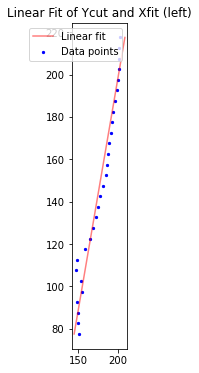

0.46017073536945796


In [118]:
fit = np.polyfit(ycut_left, xfit_left,1)
ang_coeff = fit[0]
intercept = fit[1]
fit_eq = ang_coeff*ycut_left + intercept

fig = plt.figure(figsize=[1,6])
ax = fig.subplots()
ax.plot(fit_eq,ycut_left,color = 'r', alpha = 0.5, label = 'Linear fit')
ax.scatter(xfit_left, ycut_left,s = 5, color = 'b', label = 'Data points') #Original data points
ax.set_title('Linear Fit of Ycut and Xfit (left)')
ax.legend()
plt.show()

print(ang_coeff)

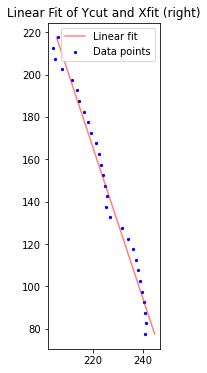

-0.27946546748768464


In [119]:
fit = np.polyfit(ycut_right, xfit_right,1)
ang_coeff = fit[0]
intercept = fit[1]
fit_eq = ang_coeff*ycut_right + intercept

fig = plt.figure(figsize=[2,6])
ax = fig.subplots()
ax.plot(fit_eq,ycut_right,color = 'r', alpha = 0.5, label = 'Linear fit')
ax.scatter(xfit_right, ycut_right,s = 5, color = 'b', label = 'Data points') #Original data points
ax.set_title('Linear Fit of Ycut and Xfit (right)')
ax.legend()
plt.show()

print(ang_coeff)

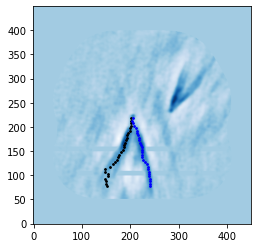

In [121]:
plt.imshow(co_zero_south,cmap='Blues',origin='lower')
plt.scatter(xfit_left,ycut_left, s=3, c='k')
plt.scatter(xfit_right,ycut_right, s=3, c='b')